In [2]:
import pandas as pd

In [11]:
df = pd.read_csv(r"data/train.csv")


In [12]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

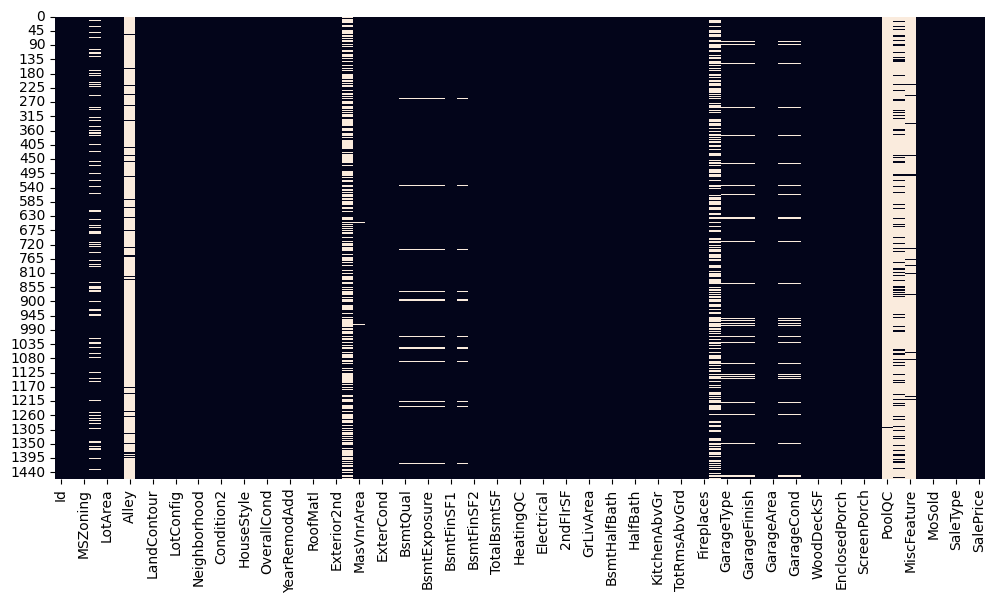

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False)
plt.show()


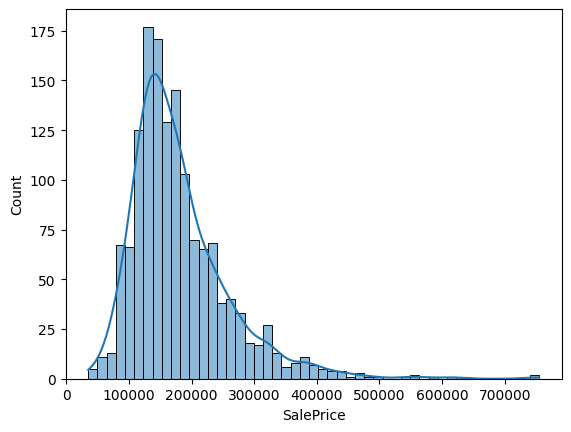

In [14]:
sns.histplot(df['SalePrice'], kde=True)
plt.show()


In [16]:
# Example ordinal mappings
ordinal_mappings = {
    'ExterQual': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    'ExterCond': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    'BsmtQual': {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    'BsmtCond': {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    'HeatingQC': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    'KitchenQual': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    'FireplaceQu': {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    'GarageQual': {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    'GarageCond': {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    'PoolQC': {'NA':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4},
    'BsmtExposure': {'NA':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4},
    'GarageFinish': {'NA':0, 'Unf':1, 'RFn':2, 'Fin':3},
}
for col, mapping in ordinal_mappings.items():
    df[col] = df[col].map(mapping).fillna(0)

categorical_cols = df.select_dtypes(include=['object']).columns
df_numeric = pd.get_dummies(df, columns=categorical_cols, drop_first=True)



/var/folders/40/h3m4kk3n3kx9r7bn1_4_nwmm0000gn/T/ipykernel_55183/3938990176.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_corr_features.values, y=top_corr_features.index, palette="viridis")


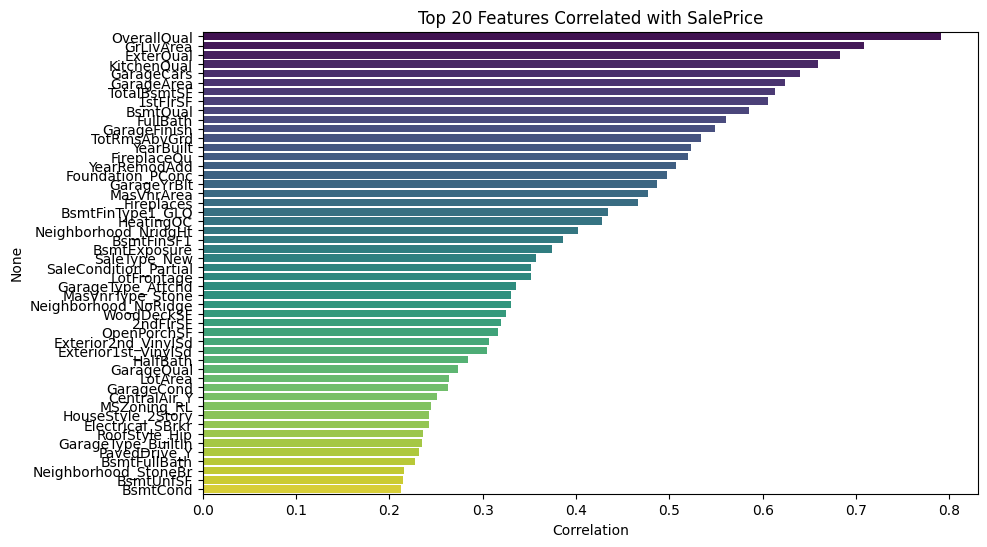

In [20]:
# Compute correlation with SalePrice
corr = df_numeric.corr()['SalePrice'].sort_values(ascending=False)

# Take top 20 most correlated features (excluding SalePrice itself)
top_corr_features = corr.drop('SalePrice').head(50)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=top_corr_features.values, y=top_corr_features.index, palette="viridis")
plt.title("Top 20 Features Correlated with SalePrice")
plt.xlabel("Correlation")
plt.show()


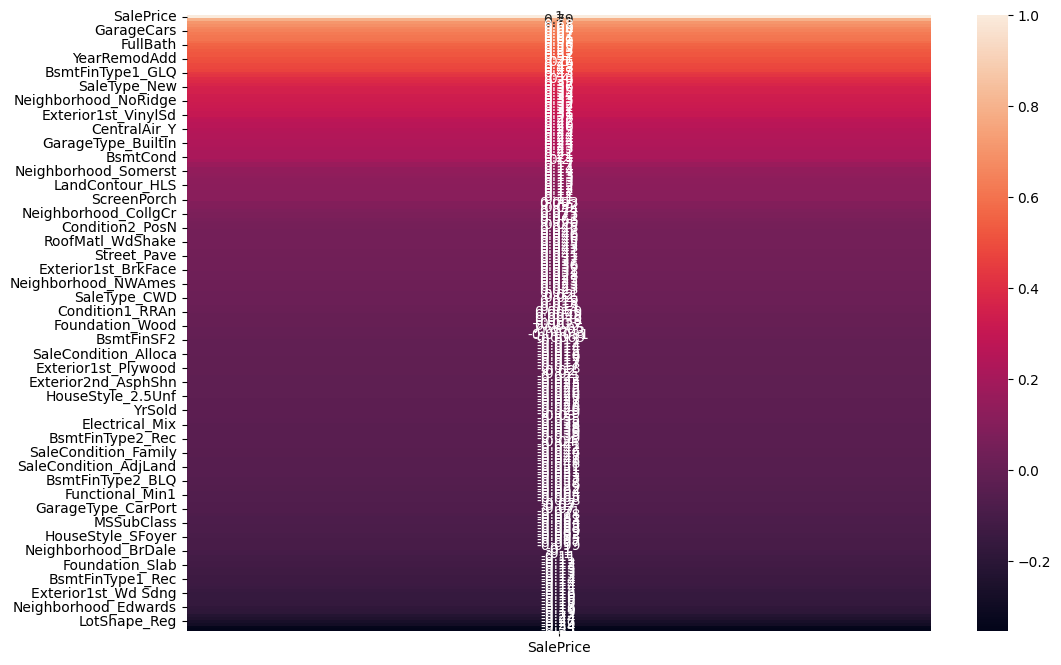

In [18]:
corr = df_numeric.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr['SalePrice'].sort_values(ascending=False).to_frame(), annot=True)
plt.show()
